# 즉시 실행

- 그래프를 생성하지 않고 함수를 바로 실행하는 명령형 프로그래밍 환경
- 직관적인 인터페이스
    - 코드를 자연스럽게 구조화하고 파이썬의 데이터 구조를 활용
    - 작은 모델과 작은 데이터를 빠르게 반복
- 손쉬운 디버깅
    - 실행중인 모델을 검토하거나 변경 사항을 테스트해보기 위해서 연산을 직접 호출
- 자연스러운 흐름 제어
    - 그래프 제어 흐름 대신에 파이썬 제어 흐름을 사용함으로써 동적인 모델 구조의 단순화





<div align="center">

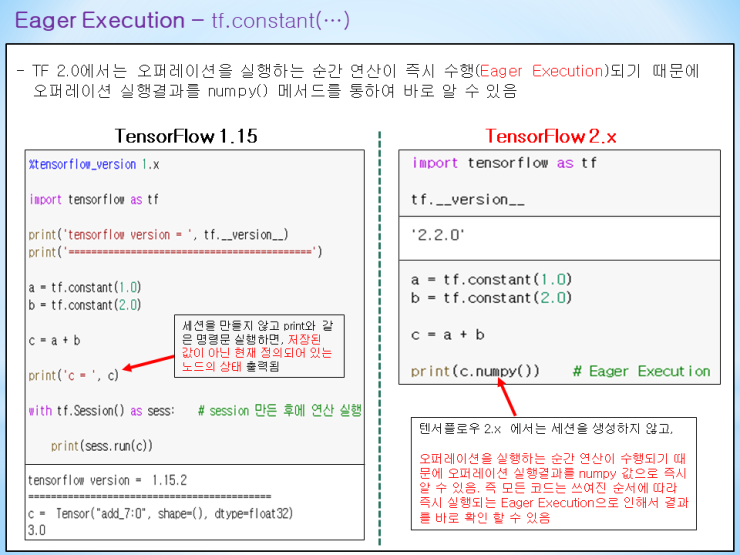

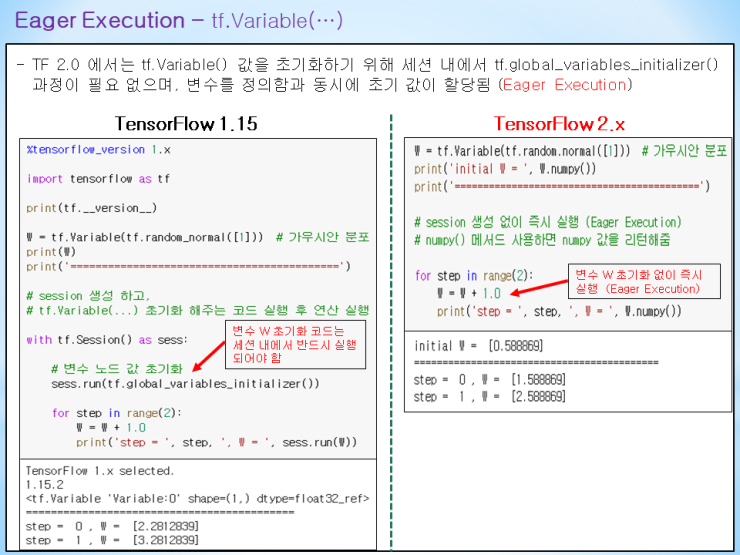

</div>

In [2]:
import tensorflow as tf
import cProfile

tf.executing_eagerly() # tf 2.0에서 즉시 실행은 기본으로 활성화되어 있음

True

In [ ]:
# tf의 수학 연산은 파이썬 객체와 numpy 배열을 tf.Tensor 객체로 변환시킴

a = tf.constant([[1, 2],
                 [3, 4]])

# 브로드캐스팅(Broadcasting) 지원
b = tf.add(a, 1)

print(a)
print(b)
# 연산자 오버로딩 지원
print(a * b)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [ ]:
# NumPy값 사용
import numpy as np

c = np.multiply(a, b)
print(c)

# 텐서로부터 numpy 값 얻기:
print(a.numpy())

[[ 2  6]
 [12 20]]
[[1 2]
 [3 4]]


# 동적인 제어 흐름

In [ ]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


# 즉시 훈련

In [ ]:
# 그래디언트 계산

w = tf.Variable([[1.0]])
with tf.GradientTape() as tape: # 모든 정방향 연산은 tape에 기록
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [ ]:
# mnist 데이터 가져오기 및 포맷 맞추기
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# 모델 생성
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [ ]:
# 즉시 실행에서는 훈련을 하지 않아도 모델을 사용하고 결과를 점검할 수 있음

for images,labels in dataset.take(1):
  print("로짓: ", mnist_model(images[0:1]).numpy())

로짓:  [[-0.02132647  0.02804985  0.00793796  0.0153531   0.01562975 -0.01287204
  -0.00948829 -0.04695632  0.00663326  0.01379219]]


In [ ]:
# 즉시 실행을 활용한 반복적인 훈련

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [ ]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # 결과의 형태를 확인하기 위해서 단언문 추가
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

def train():
  for epoch in range(3):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('에포크 {} 종료'.format(epoch))

train()

에포크 0 종료
에포크 1 종료
에포크 2 종료


Text(0, 0.5, 'Loss [entropy]')

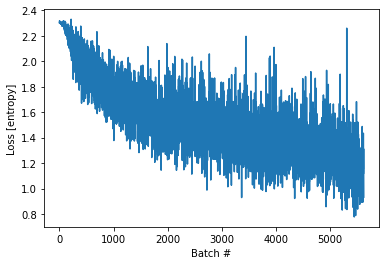

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [ ]:
# 변수와 옵티마이저

class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

# 약 3 * x + 2개의 점으로 구성된 실험 데이터
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# 최적화할 손실함수
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

# 정의:
# 1. 모델
# 2. 모델 파라미터에 대한 손실 함수의 미분
# 3. 미분에 기초한 변수 업데이트 전략
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("초기 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# 반복 훈련
for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("스텝 {:03d}에서 손실: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("최종 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

초기 손실: 69.495
스텝 000에서 손실: 66.747
스텝 020에서 손실: 30.005
스텝 040에서 손실: 13.816
스텝 060에서 손실: 6.677
스텝 080에서 손실: 3.528
스텝 100에서 손실: 2.138
스텝 120에서 손실: 1.524
스텝 140에서 손실: 1.253
스텝 160에서 손실: 1.133
스텝 180에서 손실: 1.080
스텝 200에서 손실: 1.056
스텝 220에서 손실: 1.046
스텝 240에서 손실: 1.041
스텝 260에서 손실: 1.039
스텝 280에서 손실: 1.038
최종 손실: 1.038
W = 2.9946537017822266, B = 2.0460140705108643


### 즉시 실행에서 상태를 위한 객체 사용

In [ ]:
# 즉시 실행에서 변수는 그 객체의 마지막 참조가 제거될 때까지 유지되고 그 이후 삭제

if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("gpu:0"):
    print("GPU 사용 가능")
    v = tf.Variable(tf.random.normal([1000, 1000]))
    v = None  # v는 더이상 GPU 메모리를 사용하지 않음

In [ ]:
# 객체 기반 저장

x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x) # Variable의 내부 상태를 저장

x.assign(2.)   # 변수에 새로운 값을 할당하고 저장
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

x.assign(11.)  # 저장한 후에 변수 변경

# 체크포인트로부터 값을 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [ ]:
import os

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer, # 옵티마이저, 모델을 저장
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

### 자동 미분 관련 고급편

In [ ]:
# 사용자 정의 그래디언트 -> 연산에 대해 수치적으로 안정된 그래디언트를 제공하기 위해 사용됨

@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None] # 역전파 과정에서 그래디언트의 놈을 클리핑함
  return y, grad_fn

In [ ]:
# 일반
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

# 그래디언트 계산은 x = 0일 때 잘 동작
print('x가 0일 때,', grad_log1pexp(tf.constant(0.)).numpy())
# 그러나, x = 100일 때 수치적으로 불안정하기 때문에 실패
print('x가 100일 때,', grad_log1pexp(tf.constant(100.)).numpy())

x가 0일 때, 0.5
x가 100일 때, nan


In [ ]:
# 사용자 정의 그래디언트
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

# 전처럼, 그래디언트 계산은 x = 0일 때 잘 동작
print('x가 0일 때,', grad_log1pexp(tf.constant(0.)).numpy())
# 그래디언트 계산은 x = 100일 때 역시 잘 동작
print('x가 100일 때', grad_log1pexp(tf.constant(100.)).numpy())

x가 0일 때, 0.5
x가 100일 때 1.0


GPU 사용

In [3]:
import time

def measure(x, steps):
  # 텐서플로는 처음 사용할 때 GPU를 초기화, 시간계산에서 제외
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("{} 크기 행렬을 자기 자신과 {}번 곱했을 때 걸리는 시간:".format(shape, steps))

# CPU에서 실행:
with tf.device("/cpu:0"):
  print("CPU: {} 초".format(measure(tf.random.normal(shape), steps)))

# GPU에서 실행, 가능하다면:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} 초".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: 없음")

(1000, 1000) 크기 행렬을 자기 자신과 200번 곱했을 때 걸리는 시간:
CPU: 5.276132583618164 초
GPU: 0.13750410079956055 초


# 텐서
- 일관된 유형을 가진 다차원 배열
- Python 숫자 및 문자열과 같이 내용 업데이트 불가능

In [ ]:
# 스칼라 - 0축
rank_0_tensor = tf.constant(4)
print(rank_0_tensor)

tf.Tensor(4, shape=(), dtype=int32)


In [ ]:
# 벡터 - 1축
rank_1_tensor = tf.constant([2.0, 3.0, 4.0])
print(rank_1_tensor)

tf.Tensor([2. 3. 4.], shape=(3,), dtype=float32)


In [ ]:
# 행렬 - 2축
rank_2_tensor = tf.constant([[1, 2],
                             [3, 4],
                             [5, 6]], dtype=tf.float16)
print(rank_2_tensor)

tf.Tensor(
[[1. 2.]
 [3. 4.]
 [5. 6.]], shape=(3, 2), dtype=float16)


In [ ]:
# 3축 텐서
rank_3_tensor = tf.constant([
  [[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],
  [[10, 11, 12, 13, 14],
   [15, 16, 17, 18, 19]],
  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 29]],])

print(rank_3_tensor)

tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int32)


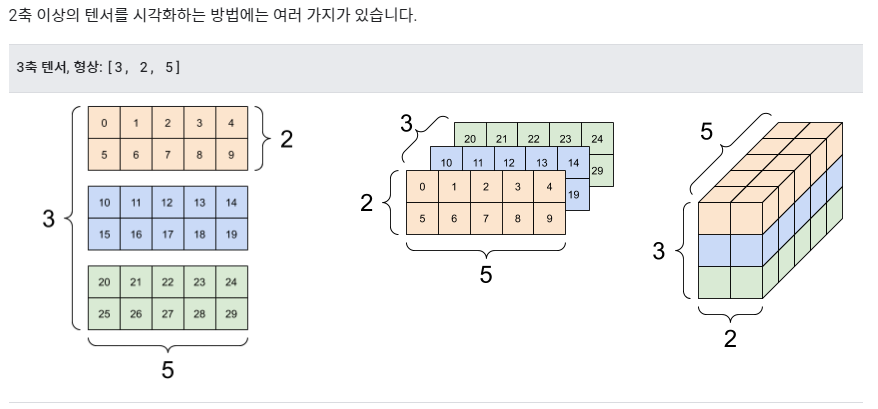

In [ ]:
# 텐서 -> numpy 배열로 변환

np.array(rank_2_tensor) # np.array() 사용
rank_2_tensor.numpy() # tf.numpy() 사용

array([[1., 2.],
       [3., 4.],
       [5., 6.]], dtype=float16)

In [ ]:
# 기본 연산

a = tf.constant([[1, 2],
                 [3, 4]])
b = tf.constant([[1, 1],
                 [1, 1]]) # Could have also said `tf.ones([2,2])`

print(tf.add(a, b), "\n")
print(tf.multiply(a, b), "\n")
print(tf.matmul(a, b), "\n")

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[3 3]
 [7 7]], shape=(2, 2), dtype=int32) 



In [ ]:
# 위와 같은 연산

print(a + b, "\n") # element-wise addition
print(a * b, "\n") # element-wise multiplication
print(a @ b, "\n") # matrix multiplication

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[3 3]
 [7 7]], shape=(2, 2), dtype=int32) 



### 형상 정보

- 형상
    - 텐서의 각 차원의 길이
- 순위
    - 텐서 차원의 수
- 축 또는 차원
    - 텐서의 특정 차원
- 크기
    - 텐서의 총 항목 수, 곱 형상 벡터

In [ ]:
# 4축 정보
rank_4_tensor = tf.zeros([3, 2, 4, 5])

print("Type of every element:", rank_4_tensor.dtype)
print("Number of dimensions:", rank_4_tensor.ndim)
print("Shape of tensor:", rank_4_tensor.shape)
print("Elements along axis 0 of tensor:", rank_4_tensor.shape[0])
print("Elements along the last axis of tensor:", rank_4_tensor.shape[-1])
print("Total number of elements (3*2*4*5): ", tf.size(rank_4_tensor).numpy())

Type of every element: <dtype: 'float32'>
Number of dimensions: 4
Shape of tensor: (3, 2, 4, 5)
Elements along axis 0 of tensor: 3
Elements along the last axis of tensor: 5
Total number of elements (3*2*4*5):  120


### 인덱싱

In [ ]:
rank_1_tensor = tf.constant([0, 1, 1, 2, 3, 5, 8, 13, 21, 34])
print(rank_1_tensor.numpy())

# 스칼라로 인덱싱하면 차원이 없음
print("First:", rank_1_tensor[0].numpy())
print("Second:", rank_1_tensor[1].numpy())
print("Last:", rank_1_tensor[-1].numpy())

[ 0  1  1  2  3  5  8 13 21 34]
First: 0
Second: 1
Last: 34


In [ ]:
# ':'로 인덱싱하면 차원이 유지됨

print("Everything:", rank_1_tensor[:].numpy())
print("Before 4:", rank_1_tensor[:4].numpy())
print("From 4 to the end:", rank_1_tensor[4:].numpy())
print("From 2, before 7:", rank_1_tensor[2:7].numpy())
print("Every other item:", rank_1_tensor[::2].numpy())
print("Reversed:", rank_1_tensor[::-1].numpy())

Everything: [ 0  1  1  2  3  5  8 13 21 34]
Before 4: [0 1 1 2]
From 4 to the end: [ 3  5  8 13 21 34]
From 2, before 7: [1 2 3 5 8]
Every other item: [ 0  1  3  8 21]
Reversed: [34 21 13  8  5  3  2  1  1  0]


In [ ]:
# 각 인덱스에 정수를 전달하면 결과는 스칼라

print(rank_2_tensor[1, 1].numpy())

4.0


In [ ]:
# 정수와 슬라이스를 조합해 인덱싱

print("Second row:", rank_2_tensor[1, :].numpy())
print("Second column:", rank_2_tensor[:, 1].numpy())
print("Last row:", rank_2_tensor[-1, :].numpy())
print("First item in last column:", rank_2_tensor[0, -1].numpy())
print("Skip the first row:")
print(rank_2_tensor[1:, :].numpy(), "\n")

Second row: [3. 4.]
Second column: [2. 4. 6.]
Last row: [5. 6.]
First item in last column: 2.0
Skip the first row:
[[3. 4.]
 [5. 6.]] 



In [ ]:
# 3축 텐서에서 마지막 특성 선택하기
print(rank_3_tensor[:, :, 4])

tf.Tensor(
[[ 4  9]
 [14 19]
 [24 29]], shape=(3, 2), dtype=int32)


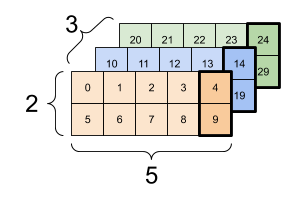

### 형상 조작하기

In [ ]:
var_x = tf.Variable(tf.constant([[1], [2], [3]]))
reshaped = tf.reshape(var_x, [1, 3])

print(var_x.shape) # 기존 형상 유지
print(var_x.shape.as_list()) # 리스트로
print(reshaped.shape) # 복제 형상

(3, 1)
[3, 1]
(1, 3)


In [ ]:
# -1을 사용해 평평하게 피기
print(tf.reshape(rank_3_tensor, [-1]))

tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29], shape=(30,), dtype=int32)


In [ ]:
# (2, 3, 5)
print(tf.reshape(rank_3_tensor, [2, 3, 5]), "\n") 

# (5, 6)
print(tf.reshape(rank_3_tensor, [5, 6]), "\n")

# 에러 발생
try:
  tf.reshape(rank_3_tensor, [7, -1])
except Exception as e:
  print(f"{type(e).__name__}: {e}")

tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]]

 [[15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]], shape=(2, 3, 5), dtype=int32) 

tf.Tensor(
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]], shape=(5, 6), dtype=int32) 

InvalidArgumentError: Input to reshape is a tensor with 30 values, but the requested shape requires a multiple of 7 [Op:Reshape]


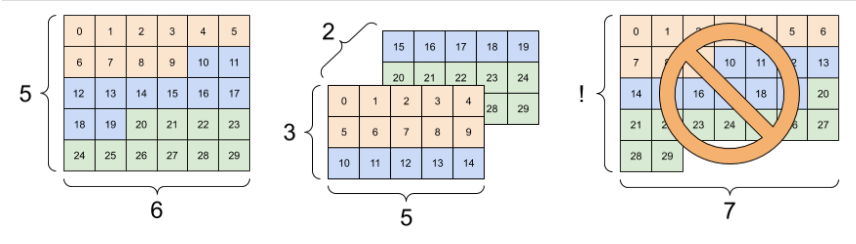

### DTypes에 대한 추가 정보

In [ ]:
# default: int32, float32

the_f64_tensor = tf.constant([2.2, 3.3, 4.4], dtype=tf.float64)
the_f16_tensor = tf.cast(the_f64_tensor, dtype=tf.float16)
the_u8_tensor = tf.cast(the_f16_tensor, dtype=tf.uint8) # float -> int

print(the_u8_tensor)

tf.Tensor([2 3 4], shape=(3,), dtype=uint8)


### 브로드캐스팅

In [ ]:
x = tf.constant([1, 2, 3])

y = tf.constant(2) # 자동으로 확장
z = tf.constant([2, 2, 2])

print(tf.multiply(x, 2))
print(x * y)
print(x * z)

tf.Tensor([2 4 6], shape=(3,), dtype=int32)
tf.Tensor([2 4 6], shape=(3,), dtype=int32)
tf.Tensor([2 4 6], shape=(3,), dtype=int32)


In [ ]:
x = tf.reshape(x,[3,1]) # 3x1
y = tf.range(1, 5) # 1x4

print(x, "\n")
print(y, "\n")
print(tf.multiply(x, y)) # 3x4

tf.Tensor(
[[1]
 [2]
 [3]], shape=(3, 1), dtype=int32) 

tf.Tensor([1 2 3 4], shape=(4,), dtype=int32) 

tf.Tensor(
[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]], shape=(3, 4), dtype=int32)


### 비정형 텐서

<br>

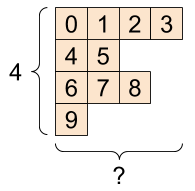

In [ ]:
ragged_list = [
    [0, 1, 2, 3],
    [4, 5],
    [6, 7, 8],
    [9]]

In [ ]:
# 비정형 에러

try:
  tensor = tf.constant(ragged_list)
except Exception as e:
  print(f"{type(e).__name__}: {e}")

ValueError: Can't convert non-rectangular Python sequence to Tensor.


In [ ]:
ragged_tensor = tf.ragged.constant(ragged_list) # 에러 발생하지 않음
print(ragged_tensor)
print(ragged_tensor.shape)

<tf.RaggedTensor [[0, 1, 2, 3], [4, 5], [6, 7, 8], [9]]>
(4, None)


### 문자열 텐서

In [ ]:
# 스칼라 문자열 텐서
scalar_string_tensor = tf.constant("Gray wolf")
print(scalar_string_tensor)

tf.Tensor(b'Gray wolf', shape=(), dtype=string)


In [ ]:
# 문자열 벡터
tensor_of_strings = tf.constant(["Gray wolf",
                                 "Quick brown fox",
                                 "Lazy dog"])

print(tensor_of_strings) # 'b' 접두사는 바이트 문자열을 뜻함

tf.Tensor([b'Gray wolf' b'Quick brown fox' b'Lazy dog'], shape=(3,), dtype=string)


In [ ]:
# 유니코드
tf.constant("🥳👍")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xf0\x9f\xa5\xb3\xf0\x9f\x91\x8d'>

In [ ]:
# split
print(tf.strings.split(scalar_string_tensor, sep=" "))
print(tf.strings.split(tensor_of_strings))

tf.Tensor([b'Gray' b'wolf'], shape=(2,), dtype=string)
<tf.RaggedTensor [[b'Gray', b'wolf'], [b'Quick', b'brown', b'fox'], [b'Lazy', b'dog']]>


In [ ]:
# String -> number
text = tf.constant("1 10 100")
print(tf.strings.to_number(tf.strings.split(text, " ")))

tf.Tensor([  1.  10. 100.], shape=(3,), dtype=float32)


In [ ]:
# 문자열 텐서를 숫자로 변환할 수 없지만, 바이트로 변환한 다음에 숫자로 변환할 수 있음

byte_strings = tf.strings.bytes_split(tf.constant("Duck"))
byte_ints = tf.io.decode_raw(tf.constant("Duck"), tf.uint8)

print("Byte strings:", byte_strings)
print("Bytes:", byte_ints)

Byte strings: tf.Tensor([b'D' b'u' b'c' b'k'], shape=(4,), dtype=string)
Bytes: tf.Tensor([ 68 117  99 107], shape=(4,), dtype=uint8)


### 희소 텐서

In [ ]:
sparse_tensor = tf.sparse.SparseTensor(indices=[[0, 0], [1, 2]],
                                       values=[1, 2],
                                       dense_shape=[3, 4])
print(sparse_tensor, "\n")

print(tf.sparse.to_dense(sparse_tensor))

SparseTensor(indices=tf.Tensor(
[[0 0]
 [1 2]], shape=(2, 2), dtype=int64), values=tf.Tensor([1 2], shape=(2,), dtype=int32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64)) 

tf.Tensor(
[[1 0 0 0]
 [0 0 2 0]
 [0 0 0 0]], shape=(3, 4), dtype=int32)


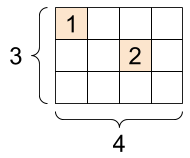

# 변수
- tf.Variable

In [ ]:
# tf.Variable은 초기화 값과 같은 dtype을 갖음
my_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
my_variable = tf.Variable(my_tensor)

bool_variable = tf.Variable([False, False, False, True])
complex_variable = tf.Variable([5 + 4j, 6 + 1j])

In [ ]:
# 변수는 텐서와 같은 데이터 구조
print("Shape: ",my_variable.shape)
print("DType: ",my_variable.dtype)
print("As NumPy: ", my_variable.numpy)

Shape:  (2, 2)
DType:  <dtype: 'float32'>
As NumPy:  <bound method BaseResourceVariable.numpy of <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>>


In [ ]:
print("A variable:",my_variable)
print("\nViewed as a tensor:", tf.convert_to_tensor(my_variable))
print("\nIndex of highest value:", tf.argmax(my_variable))

# 텐서 연산이 변수에 대해 작동함
print("\nCopying and reshaping: ", tf.reshape(my_variable, ([1,4])))

A variable: <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>

Viewed as a tensor: tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)

Index of highest value: tf.Tensor([1 1], shape=(2,), dtype=int64)

Copying and reshaping:  tf.Tensor([[1. 2. 3. 4.]], shape=(1, 4), dtype=float32)


In [ ]:
a = tf.Variable([2.0, 3.0])
b = tf.Variable(a) # 두 변수는 다른 메모리를 가짐
a.assign([5, 6])

print(a.numpy())
print(b.numpy())

print(a.assign_add([2,3]).numpy())
print(a.assign_sub([7,9]).numpy())

[5. 6.]
[2. 3.]
[7. 9.]
[0. 0.]


### 수명 주기, 이름 지정 및 감시

In [ ]:
# 변수를 추적하고 디버그하는데 도움이 되는 변수의 이름을 지정할 수 있음
a = tf.Variable(my_tensor, name="Mark")
b = tf.Variable(my_tensor + 1, name="Mark")

print(a == b)

tf.Tensor(
[[False False]
 [False False]], shape=(2, 2), dtype=bool)


### 변수 및 텐서 배치하기

In [ ]:
# CPU에 텐서와 변수 배치
with tf.device('CPU:0'):
  a = tf.Variable([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
  c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
with tf.device('CPU:0'):
  a = tf.Variable([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.Variable([[1.0, 2.0, 3.0]])

with tf.device('GPU:0'):
  k = a * b

print(k)

tf.Tensor(
[[ 1.  4.  9.]
 [ 4. 10. 18.]], shape=(2, 3), dtype=float32)
